Trying https://github.com/spdrnl/ecg/blob/master/ECG.ipynb

In [1]:
pip list | grep tensorflow

tensorflow                    2.8.0
tensorflow-addons             0.16.1
tensorflow-datasets           4.0.1
tensorflow-estimator          2.8.0
tensorflow-gcs-config         2.8.0
tensorflow-hub                0.12.0
tensorflow-io-gcs-filesystem  0.24.0
tensorflow-metadata           1.7.0
tensorflow-probability        0.16.0


### Import Libraries

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/"My Drive"/"Arrythmia "/ECGDataDenoised.zip

In [2]:
!pip install -q -U tensorflow_addons
!pip3 install py-ecg-detectors
!pip install neurokit2

In [2]:
from numpy import array
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from sklearn.model_selection import train_test_split
import sklearn
import itertools
import tensorflow_addons
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.callbacks import Callback
import tensorflow_addons as tfa
import matplotlib as mpl
mpl.style.use('seaborn')
plt.rcParams["figure.figsize"] = (13,4)
%matplotlib inline
import matplotlib.pyplot as plt 
from os import listdir 
import requests
import matplotlib.pyplot as plt
from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists
import json
import os
from tqdm import tqdm
from matplotlib import collections as matcoll
import pywt

import neurokit2 as nk

%load /content/arryhthmia_backend.py


In [28]:

def round_robin(RR_interval):

  RR_interval=RR_interval.tolist()
  wind_size = 100
  data_vect = []
  modified_data_vector = []
  ex_index = []

  #CREATE DATA VECTOR
  for i in tqdm(range(len(RR_interval))):

    if i < len(RR_interval):

      if len(RR_interval) >= i+wind_size:
        rr_interval = RR_interval[i:i+wind_size]
        data_vect.append(rr_interval)
      else:
        RR_interval.extend(RR_interval[0:100])
        rr_interval = RR_interval[i:i+wind_size]
        data_vect.append(rr_interval)

  return np.array(data_vect)

def plot_rr(rrintervals,rr_diff):
  x = rrintervals/500
  y = rr_diff
  lines = []
  for i in range(len(x)):
      pair=[(x[i],0), (x[i], y[i])]
      lines.append(pair)

  linecoll = matcoll.LineCollection(lines)
  fig, ax = plt.subplots()
  ax.add_collection(linecoll)

  plt.scatter(x,y)
  plt.xticks(x)
  plt.xlabel("Time (s)")
  plt.ylim(0,1)
  plt.title("RR Peaks")
  plt.show()

def detect_r_peaks(patient_list,case,showplots=False):
    parent_folder = '/content/ECGDataDenoised/'

    data_with_rr = pd.DataFrame()
    patient_col_id = []
    case_name = []
    mxx=0
    cnt=0
    mnn=90
    for i in tqdm(patient_list):
      # try:
        
        data = parent_folder+i+".csv"
        df = pd.read_csv(data,header=None)
        df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
        cols = df.columns
        df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce')
        lead_name='II'
        count = (df[lead_name] == 0).sum()
        if(count>0):
          print(count)
        if(df[lead_name].isnull().sum(axis = 0)>0):
          print("Null values in ",i,"is :",df[lead_name].isnull().sum(axis = 0))
        # Extract R-peaks locations
        _, rpeaks = nk.ecg_peaks(df["II"][1:], sampling_rate=500)
        rrintervals = rpeaks['ECG_R_Peaks']
        cnt+=len(rrintervals)-1
        
        rr_diff=np.diff(rrintervals)/1000
        rr_diff = np.append(0,rr_diff)

        mxx=max(len(rr_diff),mxx) #to check maximum number of rr intervals for any signal
        mnn=min(len(rr_diff),mnn)

        print(len(rrintervals),len(rr_diff))

        patient_col_id.append(i)
        case_name.append(case)
        data_with_rr=data_with_rr.append(pd.DataFrame(rr_diff).transpose())
        detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)

        if(showplots):
          plot = (nk.events_plot(rpeaks['ECG_R_Peaks'], df["aVL"]))
          plot_rr(rrintervals,rr_diff)
          print("DETRENDED")
          plot_rr(rrintervals,detrended_rri)
          
      # except:
      #   print("\nError in:",i)
    print("\n",case,"    ****Max****:",mxx)
    print("\n",case,"    ****Min****:",mnn,"\n")
    print("Total no. of RR Intervals in",case," class is:",cnt,"\n")
    data_with_rr['filename']=patient_col_id
    data_with_rr['label']=case_name
    return data_with_rr  #returning data containing RR Intervals with label

def append_r_peaks(patient_list,case,sampling_rate=500,showplots=False):
    rr_ints=[]
    rri_with_patient_id = {}
    # rr_ints=np.array(rr_ints) 
    parent_folder = '/content/ECGDataDenoised/'
    data_with_rr = pd.DataFrame()
    patient_col_id = []
    # case_name = []
    cnt=0
    for i in tqdm(patient_list):
      try:
        data = parent_folder+i+".csv"
        df = pd.read_csv(data,header=None)
        df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
        cols = df.columns
        df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce')
        lead_name='II'
        count = (df[lead_name] == 0).sum()
        if(count>0):
          print(count)
        if(df[lead_name].isnull().sum(axis = 0)>0):
          print("Null values in ",i,"is :",df[lead_name].isnull().sum(axis = 0))
        # Extract R-peaks locations
        _, rpeaks = nk.ecg_peaks(df["II"][1:], sampling_rate=500)
        rrintervals = rpeaks['ECG_R_Peaks']
        cnt+=len(rrintervals)-1
        
        rr_diff=np.diff(rrintervals)/1000
        # rr_diff = np.append(0,rr_diff) #adding this 0 for equal size of RRi , hence to plot
        rr_ints = np.append(rr_ints,rr_diff)
        patient_col_id.append(i)
        # case_name.append(case)
        data_with_rr=data_with_rr.append(pd.DataFrame(rr_diff).transpose())
        detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
        rri_with_patient_id[i]=detrended_rri
      except:
        print("\nError in:",i)

    print("Total no. of RR Intervals in",case," class is:",len(rr_ints),"\n")
    return rri_with_patient_id  #returning data containing RR Intervals with label

def extractor(case,id):
  cnt_id={}
  nsr_det_rri = []
  nsr_det_rri = np.array(nsr_det_rri)
  afib_det_rri = []
  afib_det_rri = np.array(afib_det_rri)
  afl_det_rri = []
  afl_det_rri = np.array(afl_det_rri)
  afl_list = []
  for i in id:
    label=subject_label[all_subjects[i]]
    if label in cnt_id:
      cnt_id[label]+=1
    else:
      cnt_id[label]=1
    name=all_subjects[i]
    if(label=='nsr'):
      nsr_det_rri=np.append(nsr_det_rri,nsr_rri[name])
    elif(label=='afl'):
      afl_list.append(name)
      afl_det_rri=np.append(afl_det_rri,afl_rri[name])
    else:
      afib_det_rri=np.append(afib_det_rri,afib_rri[name])
    ## 
  print(case,":",cnt_id)
  print(len(afib_det_rri),len(nsr_det_rri),len(afl_det_rri))

  p1 = np.random.permutation(afl_list)
  p2 = np.random.permutation(afl_list)
  # print(len(p1)," , ",len(p2))
  for k in p1:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  for k in p2:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  print("After patient Scrambling:",len(afl_det_rri))



  afib_vectors = round_robin(afib_det_rri)
  afl_vectors = round_robin(afl_det_rri)
  nsr_vectors = round_robin(nsr_det_rri)
  len__puncture = min(len(afib_vectors),min(len(nsr_vectors),len(afl_vectors)))
  afib_vectors = afib_vectors[:len__puncture]
  afl_vectors = afl_vectors[:len__puncture]
  nsr_vectors = nsr_vectors[:len__puncture]

  afib_rr = pd.DataFrame(afib_vectors)
  afib_rr['label']='afib'
  nsr_rr = pd.DataFrame(nsr_vectors)
  nsr_rr['label']='nsr'
  afl_rr = pd.DataFrame(afl_vectors)
  afl_rr['label']='afl'

  full_data_with_rr=pd.concat([afib_rr,nsr_rr,afl_rr])
  dict = {'nsr': 0, 'afib': 1, 'afl':2}
  full_data_with_rr.replace({'label': dict},inplace=True)
  return full_data_with_rr


def pretty_plot(history, field, fn):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index+1, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  best_index = fn(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-2, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def get_base_model(categories=3):
  return keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=[100], kernel_regularizer=regularizers.l2(0.001)),
    # keras.layers.Dense(25, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dense(3, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 3 else keras.layers.Dense(5, activation='softmax'))                   
  ])


def get_resnet_model(categories=3): #original
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(64,kernels, stride, padding='same')(X)
    # out = keras.layers.ReLU()(out)
    # out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(1, 3)(out)
    return out

  kernels = 32
  stride = 1

  inputs = keras.layers.Input([100,1])
  X = keras.layers.Conv1D(64,kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 3 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

def train_1_fold(train,test,NN):
    # train=pd.read_csv("/content/drive/MyDrive/train_with_rr_20.csv")
    train = train.sample(frac=1).reset_index(drop=True)
    train = train.sample(frac=1).reset_index(drop=True)
    full_data_with_rr=train
    full_test_set=test

    X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(full_data_with_rr.iloc[:,:-1].values, full_data_with_rr.iloc[:,-1].values,test_size=0.1, random_state=42)

    X_arhy_test, X_arhy_val, y_arhy_test, y_arhy_val = train_test_split(X_arhy_val,y_arhy_val,test_size=0.5, random_state=42)

    # The 1D convolutions expect an extra dimension in the input data 
    X_arhyl_train = np.expand_dims(X_arhy_train, -1)
    y_arhyl_train = np.expand_dims(y_arhy_train, -1)
    X_arhyl_val = np.expand_dims(X_arhy_val, -1)
    y_arhyl_val = np.expand_dims(y_arhy_val, -1)
    X_arhyl_test = np.expand_dims(X_arhy_test, -1)
    y_arhyl_test = np.expand_dims(y_arhy_test, -1)

    N = X_arhyl_train.shape[0]
    batch_size = 128
    iterations = N/batch_size
    step_size= 2 * iterations

    optimizer = keras.optimizers.Adam(lr=0.001)
    model = get_resnet_model(5) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-02, max_steps=50, smoothing=0.6)
    _ = model.fit(X_arhyl_train, y_arhyl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
    lr_finder.plot()

    lr_schedule = CyclicalLearningRate(1e-5, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    m_resnet_model = get_resnet_model(7)

    save_best_weights = ModelCheckpoint(filepath="weights.hdf5", verbose=0, save_best_only=True)

    m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = m_resnet_model.fit(X_arhyl_train, y_arhyl_train, validation_data=(X_arhyl_val, y_arhyl_val), 
                                shuffle=True, batch_size=128, epochs=8, callbacks=[save_best_weights])
    pretty_plot(history, 'loss', lambda x: np.argmin(x))
    pretty_plot(history, 'accuracy', lambda x: np.argmax(x))
    m_resnet_model.load_weights('weights.hdf5')
    print("\n****** Val data (used to tune hyperparameters for model) *****\n")
    test_stats = m_resnet_model.evaluate(X_arhyl_test, y_arhyl_test)   
    test_acc = round(test_stats[1],2)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhyl_test), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')

    X_arhy_test_10split = full_test_set.iloc[:,:-1].values
    y_arhy_test_10split = full_test_set.iloc[:,-1].values

    print("\n****** Validation data (unseen to model) *****\n")
    ###########
    val_stats=m_resnet_model.evaluate(X_arhy_test_10split, y_arhy_test_10split)
    val_acc = round(val_stats[1],4)
    

    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhy_test_10split), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test_10split, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')
    
    print("Final Accuracy:",val_acc*100,"%\n")
    return float(val_acc*100)

In [4]:
# from arryhthmia_backend import *

### Load Data

In [13]:
labels = pd.read_excel('/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx')
len(labels)

10646

In [14]:
labels=labels[(labels['Rhythm']=='AFIB') | (labels['Rhythm']=='AF') |(labels['Rhythm']=='SR')]
labels.reset_index(inplace=True,drop=True)
labels['Rhythm'].value_counts()

SR      1826
AFIB    1780
AF       445
Name: Rhythm, dtype: int64

### Preprocessing

In [7]:
afib_files = labels[labels['Rhythm']=="AFIB"]['FileName'].tolist()
afib_files.remove('MUSE_20180116_131253_72000')
nsr_files = labels[labels['Rhythm']=="SR"]['FileName'].tolist()
afl_files = labels[labels['Rhythm']=="AF"]['FileName'].tolist()
all_files = afib_files+nsr_files+afl_files

In [12]:
nsr_rri=append_r_peaks(nsr_files,"nsr",500)
afib_rri=append_r_peaks(afib_files,"afib",500)
afl_rri=append_r_peaks(afl_files,"afl",500)
# to verify total no. of total RR Intervals for each class and 
# Extract RR Peaks into a dictionary with filename

100%|██████████| 1826/1826 [00:41<00:00, 43.90it/s]


Total no. of RR Intervals in nsr  class is: 20520 



 91%|█████████ | 1619/1779 [00:35<00:02, 58.09it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1779/1779 [00:38<00:00, 46.22it/s]


Total no. of RR Intervals in afib  class is: 25124 



100%|██████████| 445/445 [00:07<00:00, 57.14it/s]

Total no. of RR Intervals in afl  class is: 7491 



In [9]:
# nsr_extraction_rr = pd.DataFrame.from_dict(nsr_rri,orient='index')
# afl_extraction_rr = pd.DataFrame.from_dict(afl_rri,orient='index')
# afib_extraction_rr = pd.DataFrame.from_dict(afib_rri,orient='index')

In [15]:
all_subjects=all_files
subject_label = {}
for i in afib_files:
    subject_label[i] = 'afib'
for i in nsr_files:
    subject_label[i] = 'nsr'
for i in afl_files:
    subject_label[i] = 'afl'

### Labelling encoding {'nsr': 0, 'afib': 1, 'afl':2}


train : {'afib': 1592, 'nsr': 1652, 'afl': 401}
22573 18567 6786
After patient Scrambling: 20358


100%|██████████| 18567/18567 [00:00<00:00, 56553.34it/s]


test : {'afib': 187, 'nsr': 174, 'afl': 44}
2551 1953 705
After patient Scrambling: 2115


100%|██████████| 1953/1953 [00:00<00:00, 423222.72it/s]


#@#@#@#@#@ Working on FOLD: 1 #@#@#@#@#@




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
392/392 [==============================] - 5s 9ms/step - loss: 0.5660 - accuracy: 0.7573 - val_loss: 0.5891 - val_accuracy: 0.7717
Epoch 2/8
392/392 [==============================] - 3s 9ms/step - loss: 0.2432 - accuracy: 0.9068 - val_loss: 0.3090 - val_accuracy: 0.8862
Epoch 3/8
392/392 [==============================] - 3s 9ms/step - loss: 0.1552 - accuracy: 0.9456 - val_loss: 0.0794 - val_accuracy: 0.9670
Epoch 4/8
392/392 [==============================] - 3s 8ms/step - loss: 0.0434 - accuracy: 0.9863 - val_loss: 0.0326 - val_accuracy: 0.9860
Epoch 5/8
392/392 [==============================] - 3s 8ms/step - loss: 0.0337 - accuracy: 0.9888 - val_loss: 0.0752 - val_accuracy: 0.9767
Epoch 6/8
392/392 [==============================] - 3s 9ms/step - loss: 0.0914 - accuracy: 0.9689 - val_loss: 0.1972 - val_accuracy: 0.9340
Epoch 7/8
392/392 [==============================] - 3s 9ms/step - loss: 0.0635 - accuracy: 0.9785 - val_loss: 0.0332 - val_accuracy: 0.9892
Epoch 8/8
392

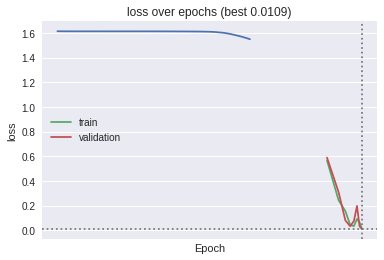

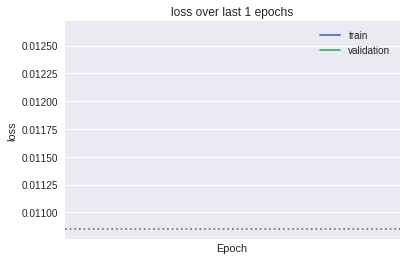

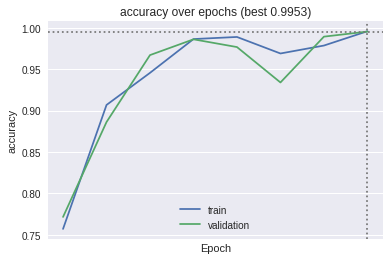

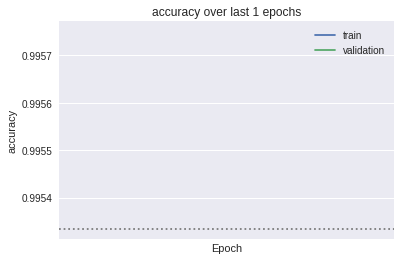


****** Val data (used to tune hyperparameters for model) *****

88/88 [==============================] - 0s 4ms/step - loss: 0.0206 - accuracy: 0.9932
Confusion matrix, without normalization
[[881   0   2]
 [  0 963   4]
 [  9   4 922]]


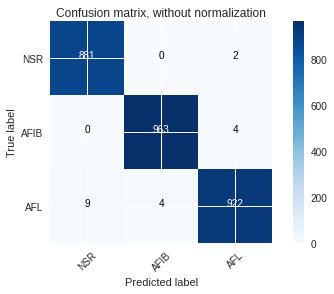


****** Validation data (unseen to model) *****

184/184 [==============================] - 1s 4ms/step - loss: 1.0854 - accuracy: 0.8879
Confusion matrix, without normalization
[[1838    0  115]
 [   0 1841  112]
 [  24  406 1523]]


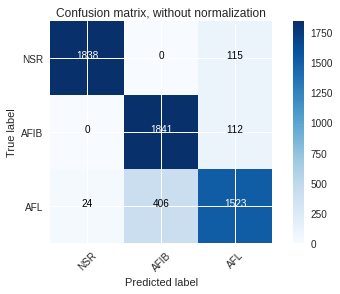

Final Accuracy: 89.0 %

train : {'afib': 1587, 'nsr': 1650, 'afl': 408}
22383 18526 6843
After patient Scrambling: 20529


100%|██████████| 18526/18526 [00:00<00:00, 56750.82it/s]


test : {'afib': 192, 'nsr': 176, 'afl': 37}
2741 1994 648
After patient Scrambling: 1944


100%|██████████| 1994/1994 [00:00<00:00, 476603.73it/s]



#@#@#@#@#@ Working on FOLD: 2 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
391/391 [==============================] - 4s 9ms/step - loss: 0.5587 - accuracy: 0.7627 - val_loss: 0.3220 - val_accuracy: 0.8611
Epoch 2/8
391/391 [==============================] - 3s 8ms/step - loss: 0.2572 - accuracy: 0.9054 - val_loss: 0.2353 - val_accuracy: 0.9100
Epoch 3/8
391/391 [==============================] - 3s 8ms/step - loss: 0.1340 - accuracy: 0.9527 - val_loss: 0.0863 - val_accuracy: 0.9665
Epoch 4/8
391/391 [==============================] - 3s 9ms/step - loss: 0.0345 - accuracy: 0.9878 - val_loss: 0.0263 - val_accuracy: 0.9878
Epoch 5/8
391/391 [==============================] - 3s 8ms/step - loss: 0.0199 - accuracy: 0.9929 - val_loss: 0.0772 - val_accuracy: 0.9723
Epoch 6/8
391/391 [==============================] - 3s 9ms/step - loss: 0.0962 - accuracy: 0.9670 - val_loss: 0.0995 - val_accuracy: 0.9640
Epoch 7/8
391/391 [==============================] - 3s 8ms/step - loss: 0.0728 - accuracy: 0.9750 - val_loss: 0.0487 - val_accuracy: 0.9849
Epoch 8/8
391

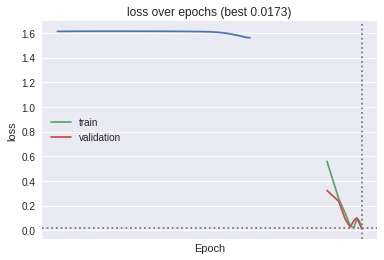

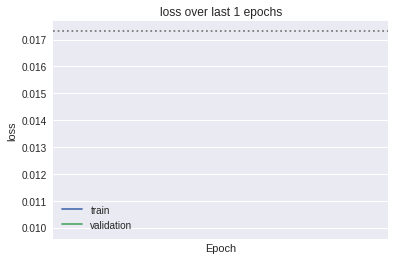

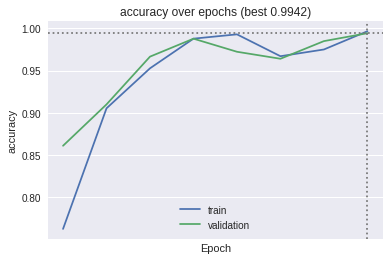

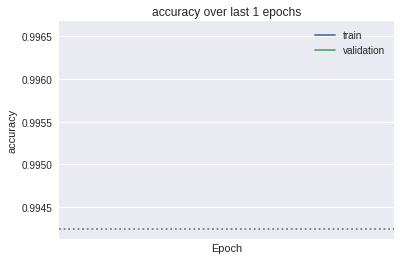


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 4ms/step - loss: 0.0173 - accuracy: 0.9942
Confusion matrix, without normalization
[[910   0   3]
 [  0 924   3]
 [  3   7 929]]


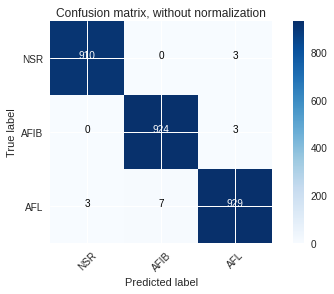


****** Validation data (unseen to model) *****

183/183 [==============================] - 1s 5ms/step - loss: 0.4953 - accuracy: 0.9160
Confusion matrix, without normalization
[[1905    0   39]
 [   0 1792  152]
 [ 145  154 1645]]


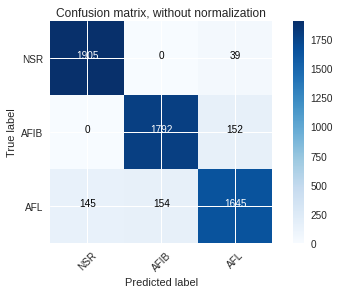

Final Accuracy: 92.0 %

train : {'afib': 1598, 'nsr': 1646, 'afl': 401}
22544 18493 6771
After patient Scrambling: 20313


100%|██████████| 18493/18493 [00:00<00:00, 58661.00it/s]


test : {'afib': 181, 'nsr': 180, 'afl': 44}
2580 2027 720
After patient Scrambling: 2160


100%|██████████| 2027/2027 [00:00<00:00, 662447.73it/s]



#@#@#@#@#@ Working on FOLD: 3 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
391/391 [==============================] - 4s 9ms/step - loss: 0.5690 - accuracy: 0.7592 - val_loss: 0.2799 - val_accuracy: 0.9016
Epoch 2/8
391/391 [==============================] - 4s 10ms/step - loss: 0.2589 - accuracy: 0.9027 - val_loss: 0.2240 - val_accuracy: 0.9164
Epoch 3/8
391/391 [==============================] - 5s 13ms/step - loss: 0.1392 - accuracy: 0.9484 - val_loss: 0.0575 - val_accuracy: 0.9798
Epoch 4/8
391/391 [==============================] - 4s 11ms/step - loss: 0.0320 - accuracy: 0.9887 - val_loss: 0.0172 - val_accuracy: 0.9932
Epoch 5/8
391/391 [==============================] - 4s 9ms/step - loss: 0.0179 - accuracy: 0.9939 - val_loss: 0.1157 - val_accuracy: 0.9658
Epoch 6/8
391/391 [==============================] - 3s 8ms/step - loss: 0.0741 - accuracy: 0.9744 - val_loss: 0.1062 - val_accuracy: 0.9730
Epoch 7/8
391/391 [==============================] - 3s 8ms/step - loss: 0.0742 - accuracy: 0.9756 - val_loss: 0.0334 - val_accuracy: 0.9895
Epoch 8/8


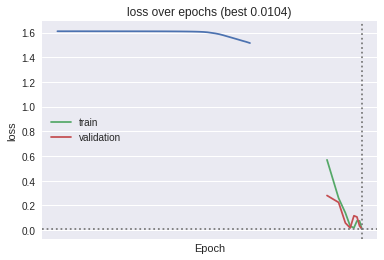

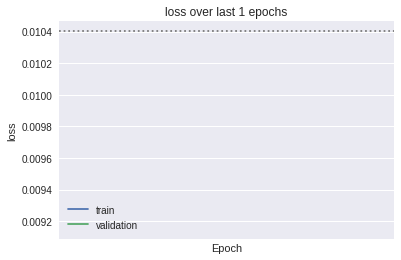

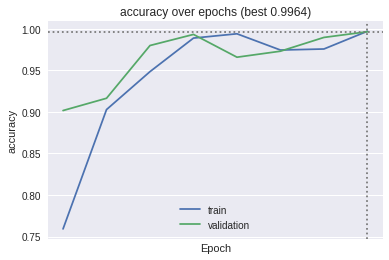

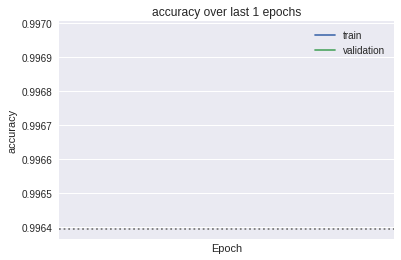


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 4ms/step - loss: 0.0183 - accuracy: 0.9913
Confusion matrix, without normalization
[[907   0   2]
 [  0 950   8]
 [  1  13 893]]


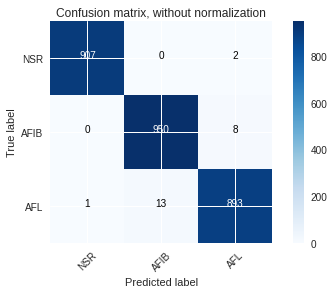


****** Validation data (unseen to model) *****

191/191 [==============================] - 1s 4ms/step - loss: 0.9519 - accuracy: 0.8846
Confusion matrix, without normalization
[[1936    0   91]
 [   0 1858  169]
 [  98  344 1585]]


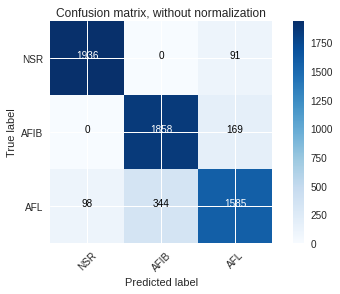

Final Accuracy: 88.0 %

train : {'afib': 1601, 'nsr': 1647, 'afl': 397}
22597 18505 6601
After patient Scrambling: 19803


100%|██████████| 18505/18505 [00:00<00:00, 60050.24it/s]


test : {'afib': 178, 'nsr': 179, 'afl': 48}
2527 2015 890
After patient Scrambling: 2670


100%|██████████| 2015/2015 [00:00<00:00, 402568.47it/s]



#@#@#@#@#@ Working on FOLD: 4 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
391/391 [==============================] - 5s 9ms/step - loss: 0.5968 - accuracy: 0.7278 - val_loss: 0.4567 - val_accuracy: 0.8325
Epoch 2/8
391/391 [==============================] - 3s 9ms/step - loss: 0.2567 - accuracy: 0.9010 - val_loss: 0.2412 - val_accuracy: 0.9081
Epoch 3/8
391/391 [==============================] - 3s 9ms/step - loss: 0.1479 - accuracy: 0.9469 - val_loss: 0.0925 - val_accuracy: 0.9676
Epoch 4/8
391/391 [==============================] - 4s 9ms/step - loss: 0.0415 - accuracy: 0.9863 - val_loss: 0.0352 - val_accuracy: 0.9885
Epoch 5/8
391/391 [==============================] - 3s 9ms/step - loss: 0.0300 - accuracy: 0.9895 - val_loss: 0.0891 - val_accuracy: 0.9690
Epoch 6/8
391/391 [==============================] - 3s 9ms/step - loss: 0.0893 - accuracy: 0.9689 - val_loss: 0.1264 - val_accuracy: 0.9503
Epoch 7/8
391/391 [==============================] - 3s 9ms/step - loss: 0.0944 - accuracy: 0.9671 - val_loss: 0.0501 - val_accuracy: 0.9798
Epoch 8/8
391

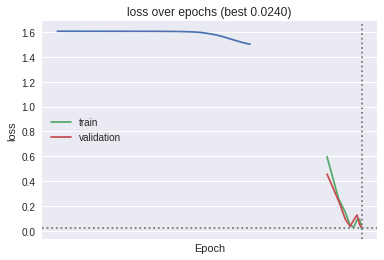

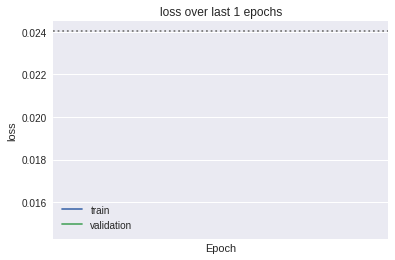

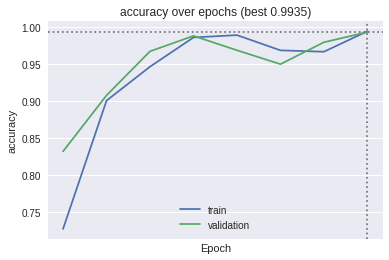

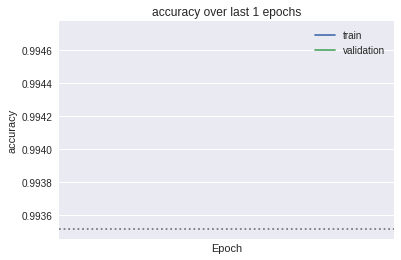


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 4ms/step - loss: 0.0221 - accuracy: 0.9924
Confusion matrix, without normalization
[[926   0   1]
 [  0 914   7]
 [ 10   3 915]]


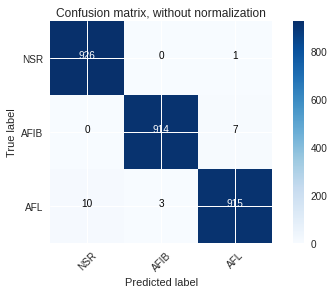


****** Validation data (unseen to model) *****

189/189 [==============================] - 1s 5ms/step - loss: 0.5435 - accuracy: 0.9113
Confusion matrix, without normalization
[[1940    0   75]
 [   0 1878  137]
 [ 125  199 1691]]


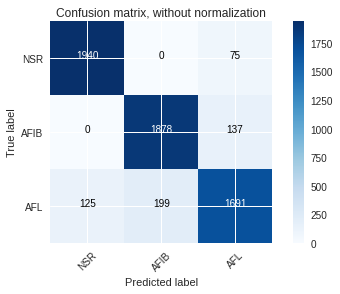

Final Accuracy: 91.0 %

train : {'afib': 1612, 'nsr': 1639, 'afl': 394}
22717 18466 6641
After patient Scrambling: 19923


100%|██████████| 18466/18466 [00:00<00:00, 58289.87it/s]


test : {'afib': 167, 'nsr': 187, 'afl': 51}
2407 2054 850
After patient Scrambling: 2550


100%|██████████| 2054/2054 [00:00<00:00, 459668.15it/s]


#@#@#@#@#@ Working on FOLD: 5 #@#@#@#@#@




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
390/390 [==============================] - 5s 9ms/step - loss: 0.5515 - accuracy: 0.7491 - val_loss: 0.2668 - val_accuracy: 0.8949
Epoch 2/8
390/390 [==============================] - 4s 9ms/step - loss: 0.2430 - accuracy: 0.9095 - val_loss: 0.2216 - val_accuracy: 0.9235
Epoch 3/8
390/390 [==============================] - 3s 9ms/step - loss: 0.1271 - accuracy: 0.9542 - val_loss: 0.0669 - val_accuracy: 0.9783
Epoch 4/8
390/390 [==============================] - 4s 9ms/step - loss: 0.0316 - accuracy: 0.9891 - val_loss: 0.0329 - val_accuracy: 0.9874
Epoch 5/8
390/390 [==============================] - 4s 9ms/step - loss: 0.0233 - accuracy: 0.9927 - val_loss: 0.0738 - val_accuracy: 0.9740
Epoch 6/8
390/390 [==============================] - 4s 9ms/step - loss: 0.0843 - accuracy: 0.9713 - val_loss: 0.1507 - val_accuracy: 0.9516
Epoch 7/8
390/390 [==============================] - 4s 9ms/step - loss: 0.0663 - accuracy: 0.9783 - val_loss: 0.0660 - val_accuracy: 0.9744
Epoch 8/8
390

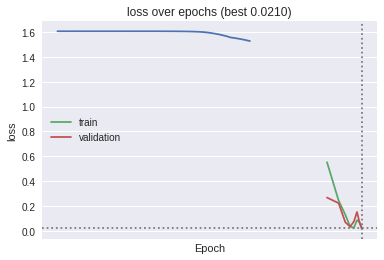

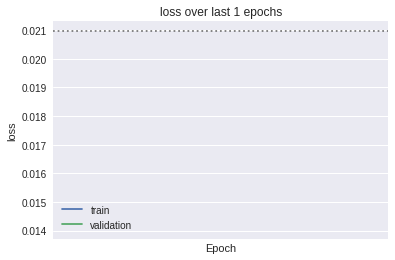

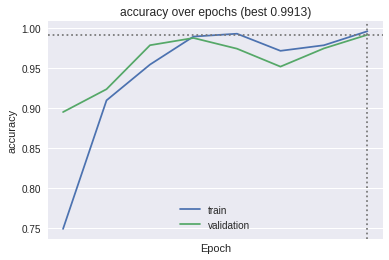

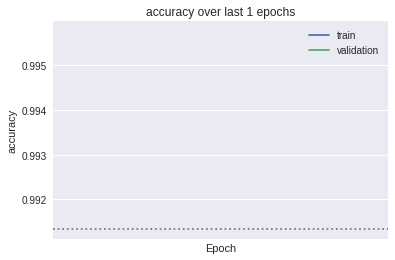


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 5ms/step - loss: 0.0241 - accuracy: 0.9921
Confusion matrix, without normalization
[[915   0   1]
 [  0 936   3]
 [  8  10 897]]


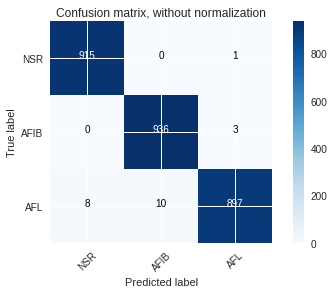


****** Validation data (unseen to model) *****

193/193 [==============================] - 1s 5ms/step - loss: 0.9358 - accuracy: 0.8874
Confusion matrix, without normalization
[[1965    0   89]
 [   0 1905  149]
 [ 295  161 1598]]


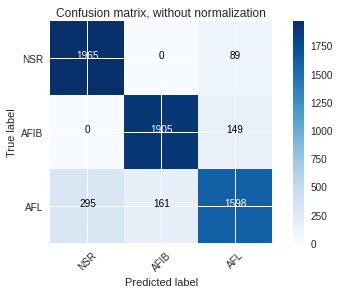

Final Accuracy: 89.0 %

train : {'afib': 1601, 'nsr': 1640, 'afl': 404}
22603 18418 6844
After patient Scrambling: 20532


100%|██████████| 18418/18418 [00:00<00:00, 55596.96it/s]


test : {'afib': 178, 'nsr': 186, 'afl': 41}
2521 2102 647
After patient Scrambling: 1941


100%|██████████| 2102/2102 [00:00<00:00, 447898.14it/s]



#@#@#@#@#@ Working on FOLD: 6 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
389/389 [==============================] - 5s 10ms/step - loss: 0.5972 - accuracy: 0.7279 - val_loss: 0.3055 - val_accuracy: 0.8740
Epoch 2/8
389/389 [==============================] - 4s 9ms/step - loss: 0.2303 - accuracy: 0.9147 - val_loss: 0.2125 - val_accuracy: 0.9215
Epoch 3/8
389/389 [==============================] - 4s 9ms/step - loss: 0.1240 - accuracy: 0.9554 - val_loss: 0.0678 - val_accuracy: 0.9758
Epoch 4/8
389/389 [==============================] - 4s 9ms/step - loss: 0.0290 - accuracy: 0.9899 - val_loss: 0.0238 - val_accuracy: 0.9891
Epoch 5/8
389/389 [==============================] - 4s 9ms/step - loss: 0.0215 - accuracy: 0.9929 - val_loss: 0.0544 - val_accuracy: 0.9783
Epoch 6/8
389/389 [==============================] - 3s 9ms/step - loss: 0.0712 - accuracy: 0.9767 - val_loss: 0.3898 - val_accuracy: 0.8867
Epoch 7/8
389/389 [==============================] - 3s 9ms/step - loss: 0.2669 - accuracy: 0.9010 - val_loss: 0.0870 - val_accuracy: 0.9667
Epoch 8/8
38

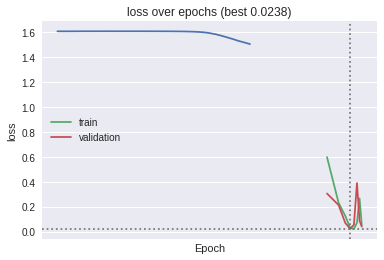

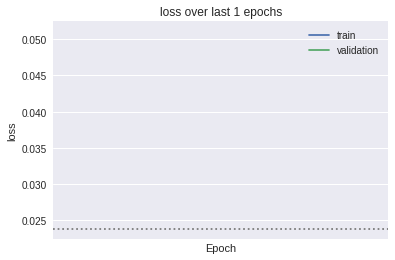

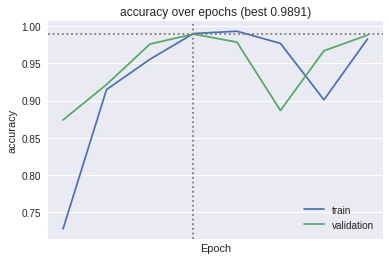

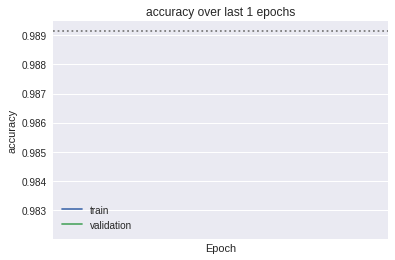


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 5ms/step - loss: 0.0263 - accuracy: 0.9888
Confusion matrix, without normalization
[[960   0   2]
 [  0 887   5]
 [  8  16 885]]


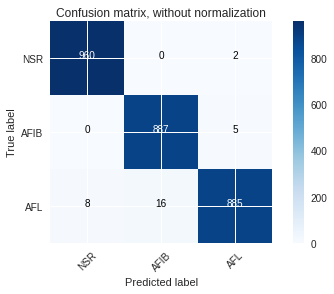


****** Validation data (unseen to model) *****

182/182 [==============================] - 1s 5ms/step - loss: 0.7773 - accuracy: 0.8721
Confusion matrix, without normalization
[[1813    0  128]
 [   0 1676  265]
 [   6  346 1589]]


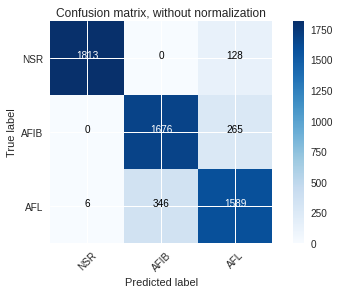

Final Accuracy: 87.0 %

train : {'afib': 1609, 'nsr': 1637, 'afl': 399}
22766 18391 6728
After patient Scrambling: 20184


100%|██████████| 18391/18391 [00:00<00:00, 57534.47it/s]


test : {'afib': 170, 'nsr': 189, 'afl': 46}
2358 2129 763
After patient Scrambling: 2289


100%|██████████| 2129/2129 [00:00<00:00, 439430.80it/s]



#@#@#@#@#@ Working on FOLD: 7 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
388/388 [==============================] - 5s 10ms/step - loss: 0.5506 - accuracy: 0.7559 - val_loss: 0.2935 - val_accuracy: 0.8855
Epoch 2/8
388/388 [==============================] - 4s 9ms/step - loss: 0.2732 - accuracy: 0.8981 - val_loss: 0.2224 - val_accuracy: 0.9282
Epoch 3/8
388/388 [==============================] - 4s 9ms/step - loss: 0.1426 - accuracy: 0.9468 - val_loss: 0.0885 - val_accuracy: 0.9659
Epoch 4/8
388/388 [==============================] - 4s 9ms/step - loss: 0.0356 - accuracy: 0.9866 - val_loss: 0.0241 - val_accuracy: 0.9913
Epoch 5/8
388/388 [==============================] - 4s 9ms/step - loss: 0.0278 - accuracy: 0.9901 - val_loss: 0.0492 - val_accuracy: 0.9826
Epoch 6/8
388/388 [==============================] - 4s 9ms/step - loss: 0.0865 - accuracy: 0.9688 - val_loss: 0.1774 - val_accuracy: 0.9609
Epoch 7/8
388/388 [==============================] - 3s 9ms/step - loss: 0.0955 - accuracy: 0.9681 - val_loss: 0.0558 - val_accuracy: 0.9801
Epoch 8/8
38

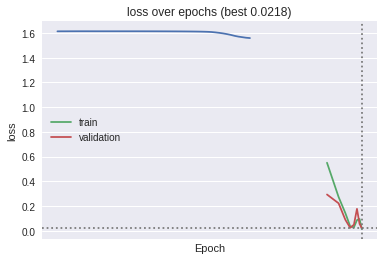

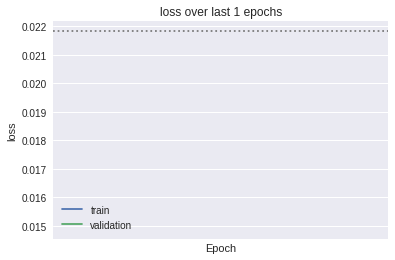

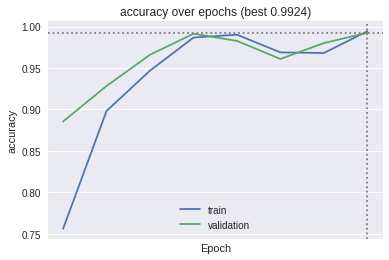

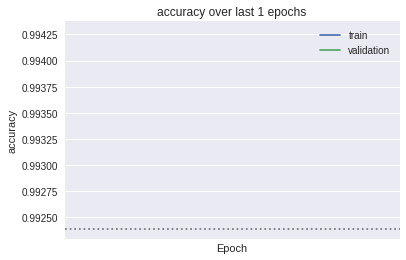


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 4ms/step - loss: 0.0222 - accuracy: 0.9920
Confusion matrix, without normalization
[[873   0   4]
 [  0 972   4]
 [  9   5 892]]


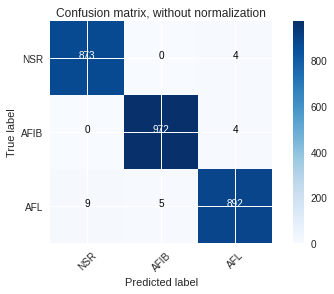


****** Validation data (unseen to model) *****

200/200 [==============================] - 1s 4ms/step - loss: 0.7825 - accuracy: 0.9089
Confusion matrix, without normalization
[[2043    0   86]
 [   0 2023  106]
 [  32  358 1739]]


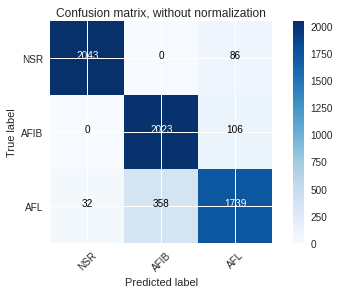

Final Accuracy: 91.0 %

train : {'afib': 1597, 'nsr': 1635, 'afl': 413}
22521 18333 6937
After patient Scrambling: 20811


100%|██████████| 18333/18333 [00:00<00:00, 56916.49it/s]


test : {'afib': 182, 'nsr': 191, 'afl': 32}
2603 2187 554
After patient Scrambling: 1662


100%|██████████| 2187/2187 [00:00<00:00, 357870.74it/s]



#@#@#@#@#@ Working on FOLD: 8 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
387/387 [==============================] - 5s 10ms/step - loss: 0.5663 - accuracy: 0.7524 - val_loss: 0.2648 - val_accuracy: 0.9065
Epoch 2/8
387/387 [==============================] - 4s 9ms/step - loss: 0.2477 - accuracy: 0.9093 - val_loss: 0.2654 - val_accuracy: 0.8855
Epoch 3/8
387/387 [==============================] - 4s 9ms/step - loss: 0.1339 - accuracy: 0.9516 - val_loss: 0.0695 - val_accuracy: 0.9749
Epoch 4/8
387/387 [==============================] - 4s 10ms/step - loss: 0.0328 - accuracy: 0.9873 - val_loss: 0.0208 - val_accuracy: 0.9931
Epoch 5/8
387/387 [==============================] - 4s 9ms/step - loss: 0.0216 - accuracy: 0.9920 - val_loss: 0.0829 - val_accuracy: 0.9764
Epoch 6/8
387/387 [==============================] - 4s 9ms/step - loss: 0.1778 - accuracy: 0.9341 - val_loss: 0.7523 - val_accuracy: 0.7633
Epoch 7/8
387/387 [==============================] - 4s 9ms/step - loss: 0.2114 - accuracy: 0.9241 - val_loss: 0.1082 - val_accuracy: 0.9647
Epoch 8/8
3

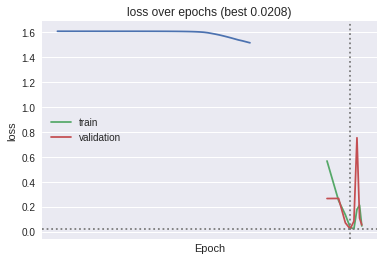

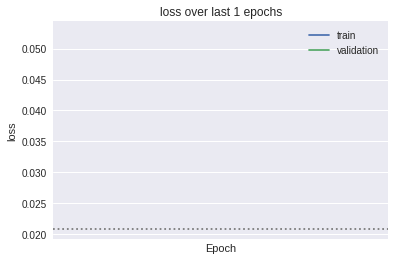

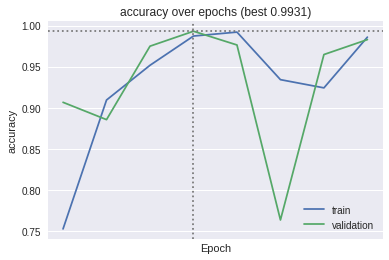

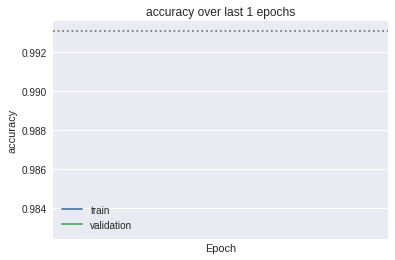


****** Val data (used to tune hyperparameters for model) *****

86/86 [==============================] - 0s 4ms/step - loss: 0.0260 - accuracy: 0.9913
Confusion matrix, without normalization
[[893   0   2]
 [  0 920   4]
 [  4  14 913]]


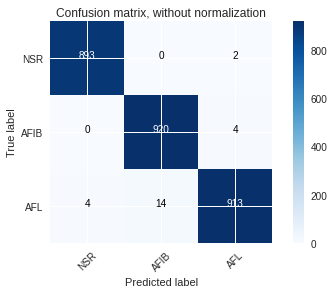


****** Validation data (unseen to model) *****

156/156 [==============================] - 1s 5ms/step - loss: 0.3108 - accuracy: 0.9346
Confusion matrix, without normalization
[[1611    0   51]
 [   0 1530  132]
 [  13  130 1519]]


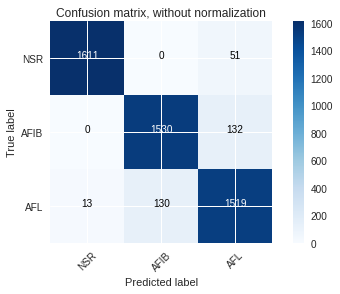

Final Accuracy: 93.0 %

train : {'afib': 1606, 'nsr': 1646, 'afl': 393}
22685 18493 6640
After patient Scrambling: 19920


100%|██████████| 18493/18493 [00:00<00:00, 57952.64it/s]


test : {'afib': 173, 'nsr': 180, 'afl': 52}
2439 2027 851
After patient Scrambling: 2553


100%|██████████| 2027/2027 [00:00<00:00, 323769.15it/s]


#@#@#@#@#@ Working on FOLD: 9 #@#@#@#@#@




/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
391/391 [==============================] - 5s 10ms/step - loss: 0.6158 - accuracy: 0.7251 - val_loss: 0.3623 - val_accuracy: 0.8544
Epoch 2/8
391/391 [==============================] - 4s 9ms/step - loss: 0.2527 - accuracy: 0.9042 - val_loss: 0.2704 - val_accuracy: 0.9012
Epoch 3/8
391/391 [==============================] - 4s 9ms/step - loss: 0.1450 - accuracy: 0.9476 - val_loss: 0.1204 - val_accuracy: 0.9553
Epoch 4/8
391/391 [==============================] - 4s 9ms/step - loss: 0.0487 - accuracy: 0.9825 - val_loss: 0.0364 - val_accuracy: 0.9863
Epoch 5/8
391/391 [==============================] - 4s 9ms/step - loss: 0.0267 - accuracy: 0.9913 - val_loss: 0.0920 - val_accuracy: 0.9643
Epoch 6/8
391/391 [==============================] - 4s 9ms/step - loss: 0.0748 - accuracy: 0.9739 - val_loss: 0.1049 - val_accuracy: 0.9661
Epoch 7/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0674 - accuracy: 0.9775 - val_loss: 0.0819 - val_accuracy: 0.9784
Epoch 8/8
3

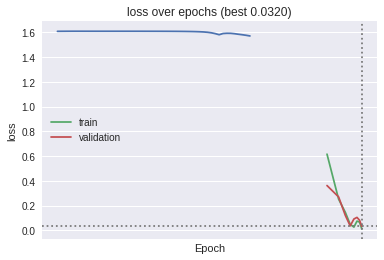

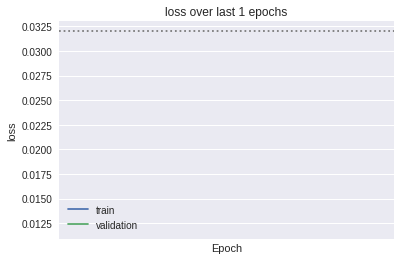

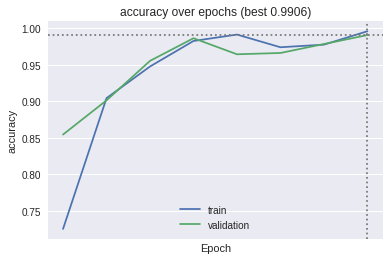

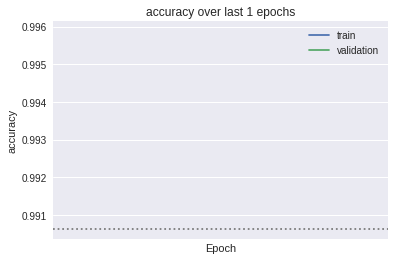


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 4ms/step - loss: 0.0398 - accuracy: 0.9856
Confusion matrix, without normalization
[[941   0   4]
 [  0 896  11]
 [  2  23 897]]


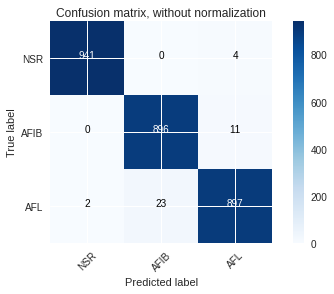


****** Validation data (unseen to model) *****

191/191 [==============================] - 1s 5ms/step - loss: 1.1067 - accuracy: 0.8890
Confusion matrix, without normalization
[[1899    0  128]
 [   0 1726  301]
 [   5  241 1781]]


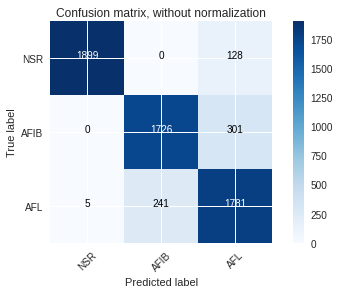

Final Accuracy: 89.0 %

train : {'afib': 1608, 'nsr': 1642, 'afl': 395}
22727 18488 6628
After patient Scrambling: 19884


100%|██████████| 18488/18488 [00:00<00:00, 54482.46it/s]


test : {'afib': 171, 'nsr': 184, 'afl': 50}
2397 2032 863
After patient Scrambling: 2589


100%|██████████| 2032/2032 [00:00<00:00, 426931.11it/s]



#@#@#@#@#@ Working on FOLD: 10 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
390/390 [==============================] - 5s 10ms/step - loss: 0.5702 - accuracy: 0.7464 - val_loss: 0.2613 - val_accuracy: 0.9041
Epoch 2/8
390/390 [==============================] - 4s 9ms/step - loss: 0.2499 - accuracy: 0.9063 - val_loss: 0.2194 - val_accuracy: 0.9149
Epoch 3/8
390/390 [==============================] - 4s 9ms/step - loss: 0.1356 - accuracy: 0.9524 - val_loss: 0.0926 - val_accuracy: 0.9668
Epoch 4/8
390/390 [==============================] - 4s 9ms/step - loss: 0.0409 - accuracy: 0.9868 - val_loss: 0.0430 - val_accuracy: 0.9852
Epoch 5/8
390/390 [==============================] - 4s 9ms/step - loss: 0.0316 - accuracy: 0.9904 - val_loss: 0.0836 - val_accuracy: 0.9719
Epoch 6/8
390/390 [==============================] - 4s 9ms/step - loss: 0.1121 - accuracy: 0.9626 - val_loss: 0.2286 - val_accuracy: 0.9373
Epoch 7/8
390/390 [==============================] - 4s 9ms/step - loss: 0.0899 - accuracy: 0.9712 - val_loss: 0.0652 - val_accuracy: 0.9776
Epoch 8/8
39

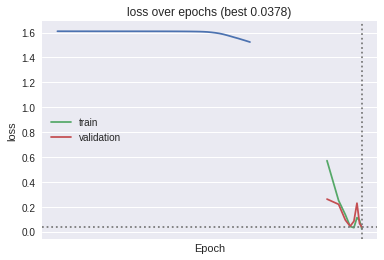

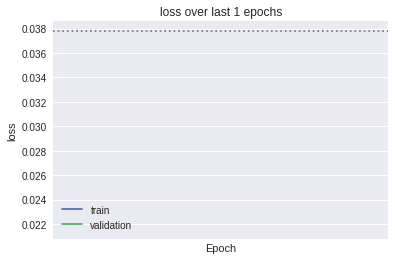

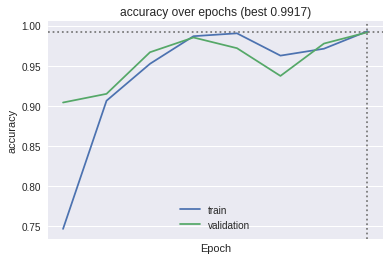

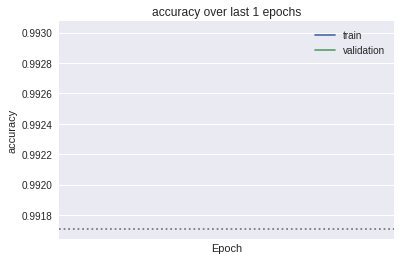


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 4ms/step - loss: 0.0359 - accuracy: 0.9917
Confusion matrix, without normalization
[[916   0   0]
 [  0 908   1]
 [ 14   8 926]]


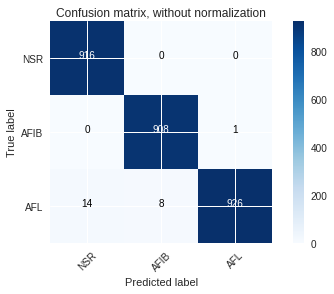


****** Validation data (unseen to model) *****

191/191 [==============================] - 1s 5ms/step - loss: 0.9003 - accuracy: 0.8768
Confusion matrix, without normalization
[[1803    0  229]
 [   0 1777  255]
 [ 111  156 1765]]


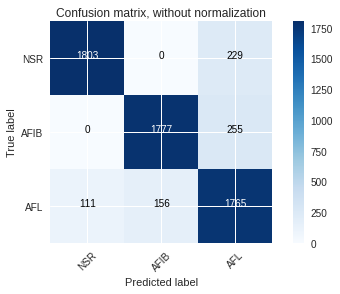

Final Accuracy: 88.0 %

10 fold acc: [89.0, 92.0, 88.0, 91.0, 89.0, 87.0, 91.0, 93.0, 89.0, 88.0]


In [32]:
# scikit-learn k-fold cross-validation
data=all_subjects

# prepare cross validation
kfold = KFold(10,shuffle=True,random_state=42)
all_fold_acc = []
# enumerate splits
count=1
for train, test in kfold.split(data):  
  full_train_set = extractor("train",train)
  full_test_set = extractor("test",test)
  print("\n#@#@#@#@#@ Working on FOLD:",count,"#@#@#@#@#@\n")
  accuracy_1_fold = train_1_fold(full_train_set,full_test_set,7)
  all_fold_acc.append(accuracy_1_fold)
  count+=1
  #1 fold done call rest part in function to complete your k fold cv
  # break
print("10 fold acc:",all_fold_acc)